## Introduction

On se lance dans le projet *N-body*. Il est conseillé d'utiliser C++, et c'est effectivement ce que nous allons faire. Néanmoins, pour des raisons pratiques, tous les plots seront faits en Python au travers de fichiers .txt.

Sans plus attendre, on va pouvoir se lancer dans les premières tâches du projet!

In [76]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit
from scipy.stats import gaussian_kde
from fancy_package import *

plt.style.use("ggplot")

___

## 1. First Task

On reste tranquillement en Python !

### 1.1. Première étape

* [X] Vérifier la forme de la fonction de densité $\rho(r)$. Comparer à la densité décrite dans le papier.
* [X] Check les choix d'unités, une fois que l'on a fixé G = 1.

La première étape est simplement de jeter un oeil au fichier `data.txt`. On commence par l'enregistrer dans un format plus pratique.

In [77]:
# let's save the file as a csv file that will be easier to read!
df = pd.read_csv("../files/data.txt", sep="\s+", header=None, names=["index", "m", "x", "y", "z", "vx", "vy", "vz", "phi", "eps"]) # the .txt file is a nice format for c++, not for us!
df['r'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)
df.to_csv("../files/data.csv", index=False) # save the file as a csv file
df = None

Jettons un oeil à ce dataframe !

In [78]:
particles_data = pd.read_csv("../files/data.csv")
particles_data.head(3)

,index,m,x,y,z,vx,vy,vz,phi,eps,r
0,0,92.4259,-0.003816,-0.079670,-0.019072,3779.62,354.734,-73.45010,0.1,0.013022,0.082010
1,1,92.4259,-0.032298,-0.249461,-0.010890,3250.59,-674.280,-18.33470,0.1,0.013022,0.251779
2,2,92.4259,0.067577,-0.810356,-0.006849,2190.86,199.053,3.86061,0.1,0.013022,0.813198


Dans (Hernquist et al.)[files/Hernquist_et_al.pdf], on trouve la densité de masse :
$$
\rho(r) = \frac{M}{2\pi} \frac{a}{r} \frac{1}{(r+a)^3}
$$
avec $M$ la masse totale et $a$ une échelle de distance charactéristique (qu'on va fit!). La distribution de masse cumulative (la masse entre $r$ et $r+dr$) est donc:

\begin{align*}
    M(R) &= \int_0^R 4 \pi r^2 \rho(r) dr \\
         &= 2M \int_0^R \frac{ar}{(r+a)^3} dr \\
         &= 2M \int_a^{a+R} \frac{a(u-a)}{u^3}du  \ \ \ (u = r + a) \\
         &= 2M \int_a^{a+R} \left( \frac{a}{u^2} - \frac{a^2}{u^3} \right) du\\
         &= 2M \left( \left[ -\frac{a}{u} \right]_a^{a+R} + \left[ \frac{a^2}{2u^2} \right]_a^{a+R} \right) \\
         &= 2M \left(
            1 - \frac{a}{a+R} + \frac{a^2}{2 (R+a)^2} - \frac{1}{2}
         \right)\\
         &= 2M \frac{1}{(R+a)^2} \left(
            \frac{1}{2}(R+a)^2 - a(R+a) + \frac{a^2}{2}
         \right)\\
         &= M \frac{R^2}{(R+a)^2}
\end{align*}

Voilà qui a une bonne tête ! Avec cette masse cumulative, on va pouvoir utiliser l'équivalent de la **loi de Gauss** pour un champ gravitationnel:
$$
\oint_{r=R} \vec{g} \cdot d\vec{S} = -4 \pi G M(R)
$$

Avec la symétrie centrale, on obtient:
$$
g_r 4 \pi R^2 = -4\pi \frac{GMR^2}{(R+a)^2} 
$$
et ainsi
$$
g_r = - \frac{GM}{(R+a)^2}
$$
qu'on intègre afin d'obtenir le potentiel gravitationnel:
$$
\phi(r) = \frac{GM}{(R+a)}
$$

Mais trêve de blabla, jettons un peu un oeil à nos données !

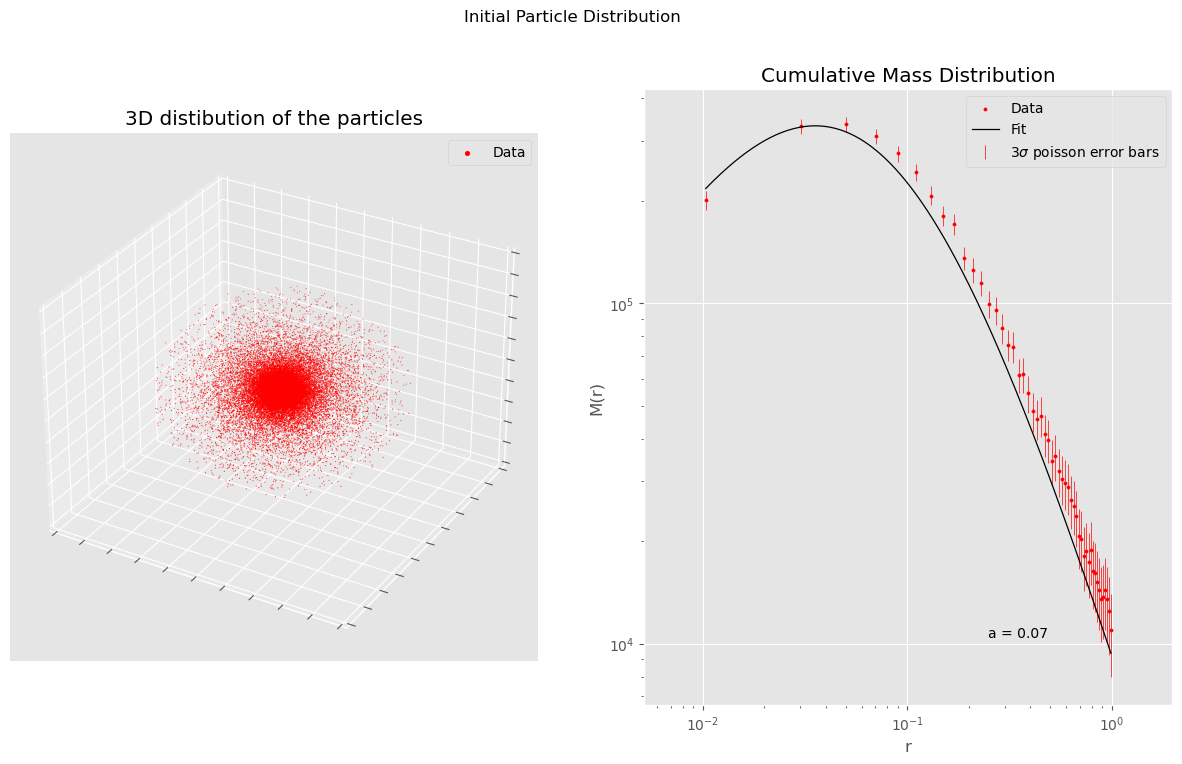

In [79]:
NBINS = 50

df_to_plot = particles_data[particles_data["r"]<1]

#3d scatter of the data
plt.figure(figsize=(15, 8))
plt.suptitle("Initial Particle Distribution")
grid = GridSpec(1, 2, hspace=1)
plt.subplot(grid[0], projection="3d")
plt.title("3D distibution of the particles")
plt.gca().scatter(df_to_plot["x"], df_to_plot["y"], df_to_plot["z"], color='red', s=0.1)
plt.gca().scatter([],[],[], label="Data", color='red', s=10)
plt.legend()
plt.xticks(plt.xticks()[0], [])
plt.yticks(plt.yticks()[0], [])
plt.gca().set_zticks(plt.gca().get_zticks(), [])

plt.subplot(grid[1])

# we need this data if we want to do a fit
hist, bin_edges = np.histogram(df_to_plot["r"], bins=NBINS, weights=df_to_plot["m"])
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2


M = df_to_plot["m"].sum()
def rho(r, a):
    rho_r = M / (2*np.pi) * (a/r) * 1/((r+a)**3)
    return rho_r * 4*np.pi*r**2 * 1/NBINS

x = np.linspace(min(bin_centers), max(bin_centers), 1000)
a, _ = curve_fit(rho, bin_centers, hist)
a = a[0]

# count the number of particles in each bin

plt.title("Cumulative Mass Distribution")


plt.scatter(bin_centers, hist, color='red', s=5, label="Data")

errors = np.sqrt(hist / (M/len(df_to_plot))) * M/len(df_to_plot) * 3 # sigma = sqrt(N)
plt.errorbar(bin_centers, hist, yerr=errors, fmt='none', color='red', elinewidth=0.5, label = "$3\sigma$ poisson error bars") # we don't see a thing...

plt.plot(x, rho(x, a), label="Fit", color='black', linewidth=0.9)
#errors = np.sqrt(rho(x, a))*5
#plt.fill_between(x, rho(x, a)-errors, rho(x, a)+errors, alpha=0.3, color='black')
plt.text(0.65, 0.11, f"a = {a:.2f}", transform=plt.gca().transAxes)

plt.xlabel("r")
plt.ylabel("M(r)")
plt.xlim(np.min(x)/2, np.max(x)*2)

plt.xscale("log")
plt.yscale("log")

plt.legend()
plt.show()

Voilà qui est fait ! Maintenant, parlons un peu des unités. En gros, si on veut simuler des galaxies, les grandeurs de masse et de distance sont à peu près fixées:

\begin{align*}
M_{tot} &= 10^{10} M_{\odot}\\
R &= 40 kpc
\end{align*}

Là on ne se pose pas vraiment de question. L'inconnue c'est plutôt le pas de temps. En effet, si on utilise $G \approx 10^{-11}$, on va devoir attendre des milliards d'années pour voir la galaxie évoluer. On décide plutôt de fixer $G=1$. La dimension du temps sera alors bien plus raisonnable, ce qu'on constate après une simple analyse dimensionnelle. On se rappelle de la formule de la *typical particle velocity*:

$$
v = \sqrt{\frac{GM_{tot}}{R}}
$$

Le temps caractéristique de collision de deux particules était alors $t_{cross} = \frac{R}{v} = \frac{R^{3/2}}{\sqrt{GM_{tot}}}$ (pour rappel, le temps de relaxation est proportionnel à $t_{cross}$ et au nombre de particules). En fixant G=1, on choisit d'exprimer le temps caractéristique :

$$
t_{cross} = \sqrt{\frac{R^3}{M_{tot}}}
$$

Mais bon en vrai je comprends pas trop ce qu'on est censé dire à partir de là...

### 1.2. Deuxième Étape

* [ ] Calculer les forces appliquées à chaque particule de manière directe (avec $\epsilon$). Tester pour différentes valeurs de $\epsilon$.
* [ ] Comparer des calculs directs de forces à la solution exacte donnée par le livre *Galactic Dynamics* (aussi appelée **loi de Gauss** cf ci-dessus, on a déjà la valeur de la Force).
* [ ] Calculer le temps de relaxation du system et commenter le lien avec $\epsilon$.

Pour ça, on va avoir besoin d'un calcul direct des forces. Le script en Python part pour 44h (à cause de `iterrows` je crois, en vrai ça doit pas être si long que ça), donc ça ne va pas le faire. On va préférer créer un programme en C++ qui exportera le résultat dans un fichier.

Commençons par tester la méthode de calcul direct combinée avec la méthode d'Euler. On peut tester ça tout d'abord sur un problème à trois corps stable.

Dataframe loaded for 3 body direct summation of shape:  (15003, 10)


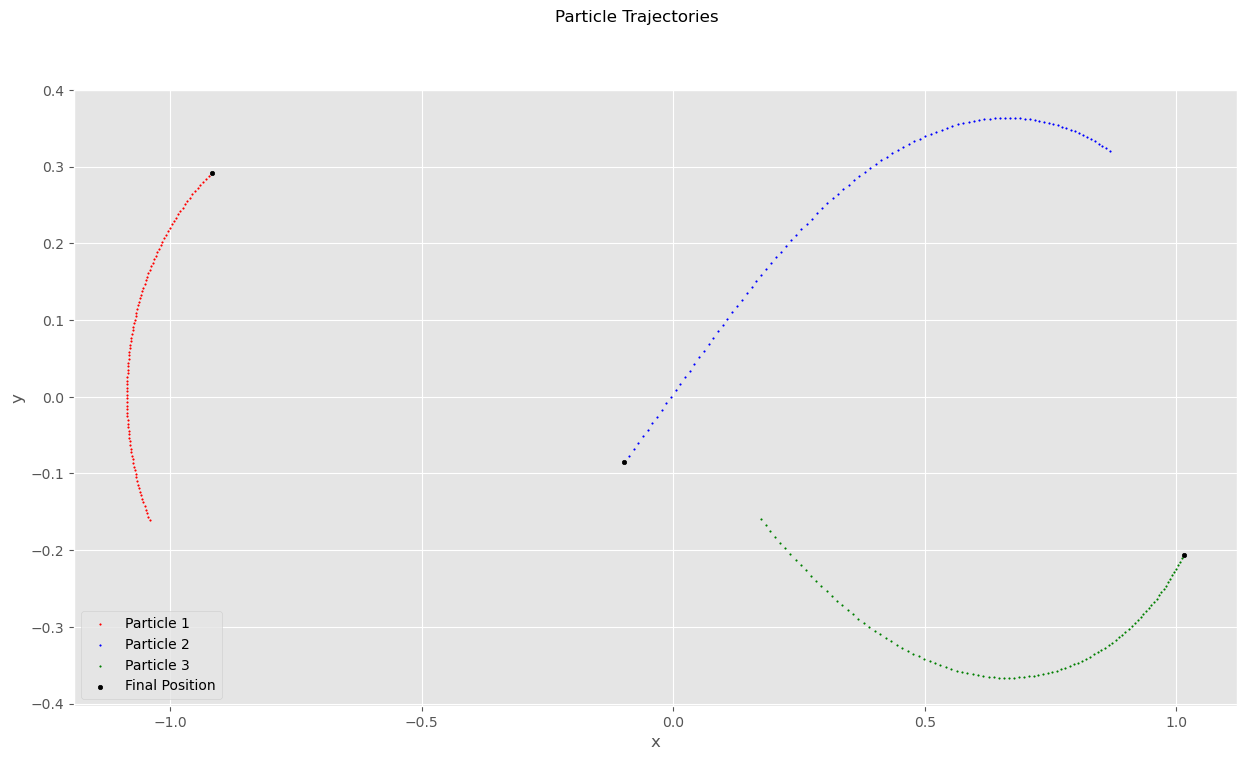

In [80]:
particles_3body = pd.read_csv("../files/tests/DIRECT_EULER_N=3_stable.csv")
print("Dataframe loaded for 3 body direct summation of shape: ", particles_3body.shape)
start_time = 1000
n_traj  = 100 # we draw this number of points for each one of our 3 particles

# let's make the plot!
start_time = start_time - start_time%3

df_frame = particles_3body.iloc[start_time:start_time+3*n_traj]
df1 = df_frame.iloc[::3]
df2 = df_frame.iloc[1::3]
df3 = df_frame.iloc[2::3]

fig = plt.figure(figsize=(15, 8))
plt.suptitle("Particle Trajectories")
plt.scatter(df1["x"], df1["y"], color='red', s=1, label="Particle 1")
plt.scatter(df2["x"], df2["y"], color='blue', s=1, label="Particle 2")
plt.scatter(df3["x"], df3["y"], color='green', s=1, label="Particle 3")
plt.scatter([df1["x"].iloc[-1], df2["x"].iloc[-1], df3["x"].iloc[-1]], [df1["y"].iloc[-1], df2["y"].iloc[-1], df3["y"].iloc[-1]], color='black', s=10, label="Final Position")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Ca a l'air de bien marcher ! Maintenant, on peut tester le calcul directe des forces sur les particules fournies par le prof. Il va falloir s'accrocher un peu parce qu'on a beaucoup de choses à calculer.

```python
# TODO: try direct calculation for different epsilon's
```

On commence par comparer la force théorique à la force calculée par la sommation directe.

In [81]:
direct_force_data = pd.read_csv("../files/output/DIRECT_FORCES_eps=0.000000_data.csv")
df = pd.concat([ # df will contain everything: force from direct, tree and quadtree
    particles_data[["m", "x", "y", "z", "r", "vx", "vy", "vz", "phi", "eps"]],
    direct_force_data[["fx", "fy", "fz"]].rename(columns={"fx": "fx_direct", "fy": "fy_direct", "fz": "fz_direct"}),
], axis = 1)

df["fr_direct"] = (df["x"] * df["fx_direct"] + df["y"] * df["fy_direct"] + df["z"] * df["fz_direct"]) / df["r"]

La question maitenant, c'est que faire de ça ? Que souhaite-t-on comparer, calculer ? Eh bien on va comparer les différentes réalisations de $F_r(r)$ à la valuer théorique de $F_r^{th}(r)$. On fait ça avec un scatter plot.

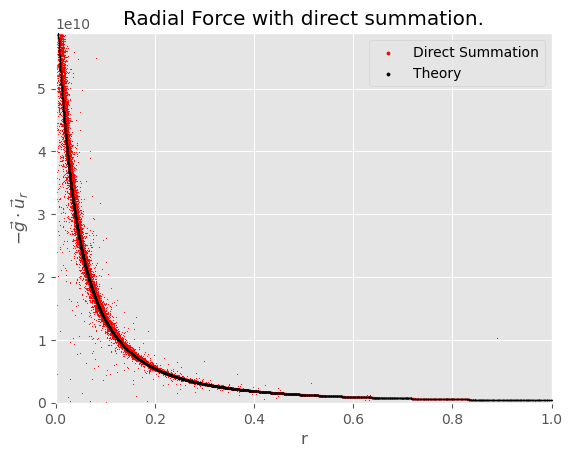

In [82]:
M = df["m"].sum()
m = df["m"].mean() # it is actually the same mass for al of them

plt.scatter(df["r"], -df["fr_direct"], s=0.1, color="red")
plt.scatter([], [], label=r"Direct Summation", color="red", s=5)

# theoretical curve
def f(r, a=0.08):
    return -M*m / (r+a)**2

df["fr_theory"] = f(df["r"])

r = np.linspace(0, 1)
plt.scatter(df["r"], -df["fr_theory"], s=0.1, color="black", zorder=10)
plt.scatter([], [], label="Theory", color="black", s=5)

plt.xlim(0, 1)
plt.ylim(0, -df["fr_direct"].quantile(0.01))
plt.title("Radial Force with direct summation.")
plt.legend()
plt.xlabel("r")
plt.ylabel(r"$-\vec{g} \cdot \vec{u}_r$")
plt.show()

On constate qu'il y a quelques points qui, même à très faible rayon, sont négatif, i.e. sont tirés dans le mauvais sens. Probablement ont-ils juste au dessus d'eux un autre point qui les attire beaucoup. Augmenter $\epsilon$ devrait diminuer cet effet, homogénéiser les forces, faire une moyenne sur nos petits points.

Ca on se permet de le garder pour plus tard. Il est également intéressant de se demander dans quelle mesure la courbe calculée par sommation directe est proche de la courbe théorique.

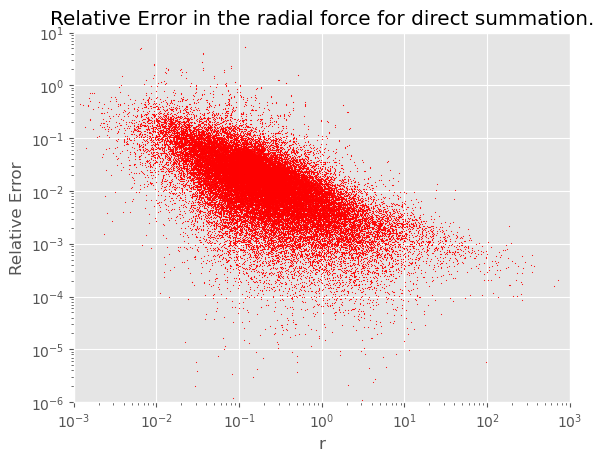

In [83]:
relative_error = np.abs(df["fr_direct"] - df["fr_theory"]) / np.abs(df["fr_theory"])
plt.scatter(df["r"], relative_error, s=0.1, color="red")
plt.yscale("log")
plt.xscale("log")
plt.xlim(1e-3, 1e3)
plt.ylim(1e-6, 10)
plt.xlabel("r")
plt.ylabel("Relative Error")
plt.title("Relative Error in the radial force for direct summation.")
plt.show()

Une fois de plus:
```python
#TODO : do this for different softenings
```

___

## 2. Second Task: tree-code

### 2.1. Force Calculations
* [ ] code the multipole expansion
* [X] create the tree
* [X] decide on a distance based criterion
* [ ] compute force, compare with the correct result, and compare computationnal cost.
* [ ] compare result with direct summation, try different opening angles and different softening

Bon, on va commencer par quelques calculs. Supposons qu'on souhaite calculer la force qui va s'appliquer à une particule $\mathcal{P}(\vec{r})$. Au loin, on un tout un tas the $n$ particules dont on souhaite calculer l'influence gravitationnelle en groupe. En d'autres termes, on souhaite calculer l'influence de ce groupe de particule à une distance $r$. La formule exacte pour le potentiel est la suivante :
$$
\phi(\vec{r}) = -G \sum_{k=1}^{n} \frac{m_k}{\left|\vec{r} - \vec{r_k} \right|}
$$

Le problème, c'est que dans ce cas, on a pour chaque particule une somme de n = O(N) termes à faire $\implies$ au total O(N^2). L'idée c'est d'approximer ce potentiel par la formule suivante :
$$
\phi(\vec{r}) \approx -G \frac{M_{tot}}{\left|\vec{r} - \vec{R}_{COM}\right|}

- \frac{G}{2} \sum_{\alpha, \beta}^{3} \frac{Q_{\alpha \beta}(r_\alpha - R_{COM,\alpha})(r_{\beta} - R_{COM,\beta})}{\left|\vec{r} - \vec{R}_{COM} \right|^5}\\
= -G \frac{M_{tot}}{\left|\vec{r} - \vec{R}_{COM}\right|}

- \frac{G}{2} \sum_{\alpha, \beta}^{3} \frac{(\vec{r} - \vec{R}_{COM})^T Q (\vec{r} - \vec{R}_{COM})}{\left|\vec{r} - \vec{R}_{COM} \right|^5}
$$

avec
$$
Q_{\alpha, \beta} = \sum_{k} m_k (3\tilde{r_k}_i \tilde{r_k}_j - \delta_{ij} \left| \tilde{r}_k\right|^2)
$$

Il n'y plus qu'à en prendre le gradient:
$$
\vec{g} = -\vec{\nabla}\phi(\vec{r}) \\
$$
et on obtient:
$$
\vec{g} = -G \frac{M}{\left(\vec{r} - \vec{R}_{COM}\right)^2} \frac{\vec{r}}{\left| \vec{r} \right|} - \frac{G}{2}...
$$

Let's compute the derivatives of the quadrupole term ($\nabla = \frac{\partial}{\partial r_{\mu}} = \frac{\partial}{\partial \tilde{r}_{\mu}}$ with $\tilde{r} = \vec{r} - \vec{R}_{COM}$):
\begin{align*}
\frac{\partial}{\partial r_{\mu}} Q_{\alpha,\beta}\tilde{r}^\alpha \tilde{r}^\beta &= Q_{\alpha,\beta}(\frac{\partial}{\partial r_{\mu}}\tilde{r}^\alpha) \tilde{r}^\beta + Q_{\alpha,\beta} \tilde{r}^\alpha (\frac{\partial}{\partial r_{\mu}}\tilde{r}^\beta)\\
 &= Q_{\mu,\beta} \tilde{r}^\beta + Q_{\alpha,\mu} \tilde{r}^\alpha \\
 &= 2 Q_{\mu,\beta} \tilde{r}^\beta \ \text{since Q is symetric}
\end{align*}

Thus:
$$
\frac{\partial}{\partial \tilde{r}} (\tilde{r}^T Q \tilde{r}) = 2Q\tilde{r}
$$

We need one last derivative:
$$
\frac{\partial}{\partial \tilde{r}} \left| \tilde{r} \right|^5 = 5\left|\tilde{r}\right|^4 \frac{\vec{\tilde{r}}} {\left| \tilde{r} \right|} = 5 \left|\tilde{r}\right|^3 \vec{\tilde{r}}
$$

The derivative of the full quotient is thus:

$$
\frac{\partial}{\partial \tilde{r}}(...) = \frac{
    2Q\tilde{r} \cdot \left|\tilde{r}\right|^5 - 5 (\tilde{r}^{T}Q\tilde{r}) \left| \tilde{r} \right| ^3 \tilde{r}
}{
    \left| \tilde{r} \right| ^{10}
}
$$

Thus we finally get, after multiplying by the mass of the particle:
$$
\vec{F} = -\frac{Gm}{\left|\tilde{r}\right|^2} \frac{M\tilde{r}}{\left| \tilde{r} \right|} - \frac{Gm}{2 \left| \tilde{r} \right|^4} \left[ \frac{
    2Q \tilde{r}
}{
    \left| \tilde{r} \right|
} - \frac{
    5 (\tilde{r}^{T}Q\tilde{r}) \tilde{r}
}{
    \left| \tilde{r} \right| ^{3}
}
\right]
$$

with $\tilde{r} = \vec{r} - \vec{R}_{COM}$. All the quadrupole terms are indeed $\propto \frac{1}{r^4}$.

On fait ça un peu dans le mauvais ordre, mais commençons par le calcul de l'ensemble de nos particules. On fera des tests de débug plus tard.

In [103]:
monopole_force_data = pd.read_csv("../files/output/TREE-MONO_FORCES_data.csv")
df["fx_mono"], df["fy_mono"], df["fz_mono"] = monopole_force_data["fx"], monopole_force_data["fy"], monopole_force_data["fz"]
df["fr_mono"] = (df["x"] * df["fx_mono"] + df["y"] * df["fy_mono"] + df["z"] * df["fz_mono"]) / df["r"]

quadru_force_data = pd.read_csv("../files/output/TREE-QUAD_FORCES_data.csv")
df["fx_quad"], df["fy_quad"], df["fz_quad"] = quadru_force_data["fx"], quadru_force_data["fy"], quadru_force_data["fz"]
df["fr_quad"] = (df["x"] * df["fx_quad"] + df["y"] * df["fy_quad"] + df["z"] * df["fz_quad"]) / df["r"]

Bon, tout est prêt, on peut regarder ce que ça donne. Cette fois on ne veut pas vraiment comparer à la courbe théorique, mais plutôt à la direct summation. Mais bon en même temps la courbe théorique elle permet d'y voir quelque chose, donc on va aussi l'utiliser.

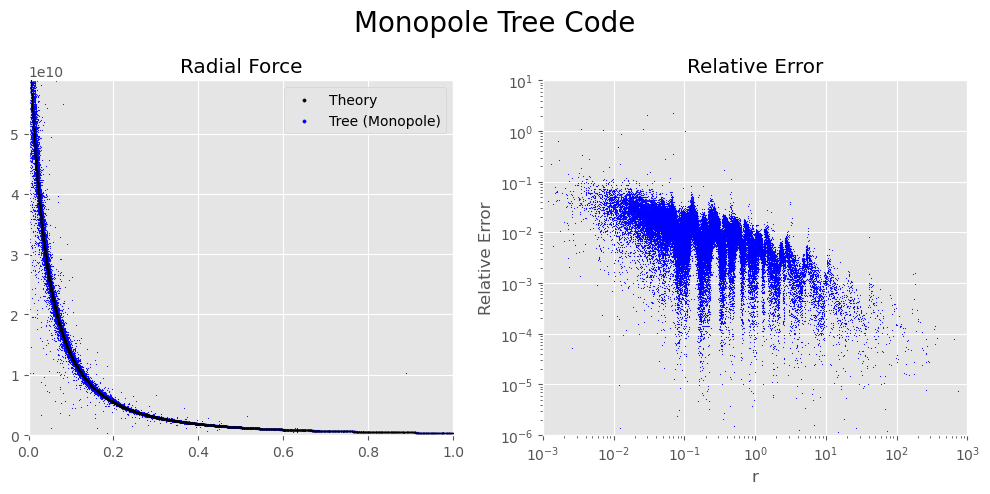

In [104]:
M = df["m"].sum()
m = df["m"].mean()

plt.figure(figsize=(10, 5))
plt.suptitle("Monopole Tree Code", fontsize=20)
plt.subplot(1, 2, 1)
plt.title("Radial Force")
plt.scatter(df["r"], -df["fr_theory"], s=0.1, color="black", zorder=10)
plt.scatter([], [], label=r"Theory", color="black", s=5)
plt.scatter(df["r"], -df["fr_mono"], s=0.1, color="blue")
plt.scatter([], [], label=r"Tree (Monopole)", color="blue", s=5)
plt.xlim(0, 1)
plt.ylim(0, -df["fr_direct"].quantile(0.01))
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Relative Error")
plt.scatter(df["r"], np.abs(df["fr_mono"] - df["fr_direct"]) / np.abs(df["fr_direct"]), s=0.1, color="blue")
plt.yscale("log")
plt.xscale("log")
plt.xlim(1e-3, 1e3)
plt.ylim(1e-6, 10)
plt.xlabel("r")
plt.ylabel("Relative Error")
plt.tight_layout()
plt.show()


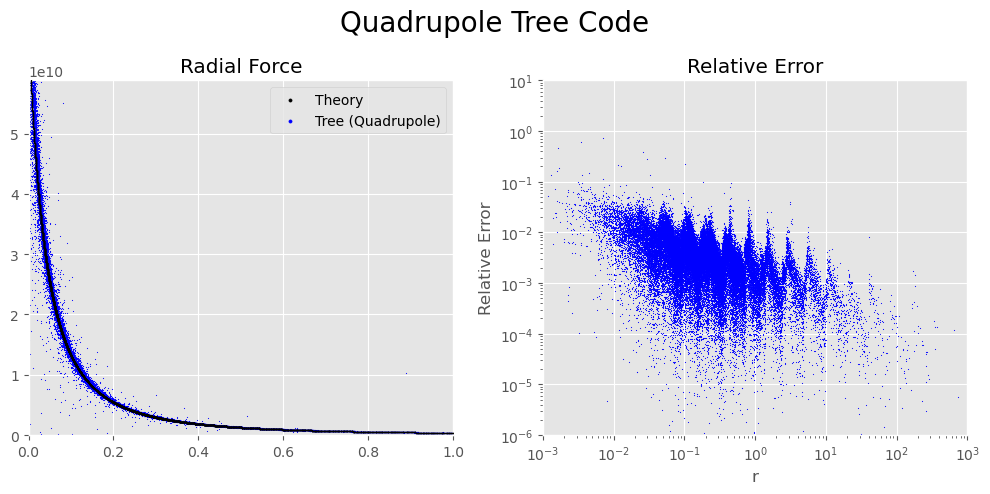

In [107]:
M = df["m"].sum()
m = df["m"].mean()

plt.figure(figsize=(10, 5))
plt.suptitle("Quadrupole Tree Code", fontsize=20)
plt.subplot(1, 2, 1)
plt.title("Radial Force")
plt.scatter(df["r"], -df["fr_theory"], s=0.1, color="black", zorder=10)
plt.scatter([], [], label=r"Theory", color="black", s=5)
plt.scatter(df["r"], -df["fr_quad"], s=0.1, color="blue")
plt.scatter([], [], label=r"Tree (Quadrupole)", color="blue", s=5)
plt.xlim(0, 1)
plt.ylim(0, -df["fr_direct"].quantile(0.01))
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Relative Error")
plt.scatter(df["r"], np.abs(df["fr_quad"] - df["fr_direct"]) / np.abs(df["fr_direct"]), s=0.1, color="blue")
plt.yscale("log")
plt.xscale("log")
plt.xlim(1e-3, 1e3)
plt.ylim(1e-6, 10)
plt.xlabel("r")
plt.ylabel("Relative Error")
plt.tight_layout()
plt.show()

In [106]:
print("Average relative error (monopole):", f'{(np.abs(df["fr_mono"] - df["fr_direct"]) / np.abs(df["fr_direct"])).mean():.3%}')
print("Average relative error (quadrupole):", f'{(np.abs(df["fr_quad"] - df["fr_direct"]) / np.abs(df["fr_direct"])).mean():.3%}')
print("Average relative difference between both:", f'{(np.abs(df["fr_quad"] - df["fr_mono"]) / np.abs(df["fr_direct"])).mean():.3%}')

Average relative error (monopole): 1.091%
Average relative error (quadrupole): 0.445%
Average relative difference between both: 0.804%


Et voilà! Bon, pour une raison indéterminée, le quadrupole a de moins bonnes performances que le monopole. On va faire quelques tests pour invesitguer cette étrangetée. On commence par créer nos particules dans la disposition suivante :

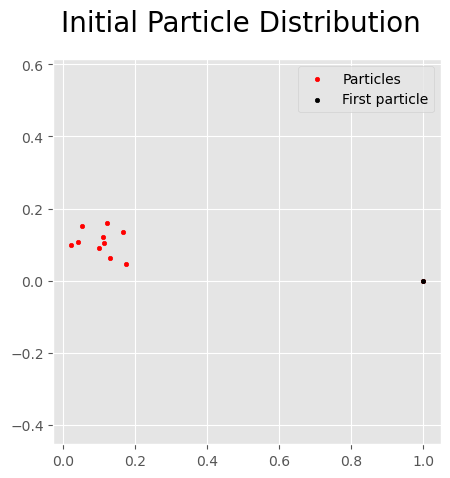

In [88]:
df_test = pd.DataFrame(columns=["m", "x", "y", "z", "vx", "vy", "vz", "eps", "phi"])
df_test.loc[0] = [1, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] # let's put the particle at mass 0 so that is doesn't get included in the force calculation
# let's add some random particles all focused around zero in the x-y plane
N = 10
std = 0.05
np.random.seed(10)
for i in range(1, N+1):
    x = np.random.normal(0.1, std)
    y = np.random.normal(0.1, std)
    df_test.loc[i] = [1, x, y, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# let's take a look at our little system:
plt.figure(figsize=(5, 5))
plt.suptitle("Initial Particle Distribution", fontsize=20)
plt.scatter(df_test["x"], df_test["y"], color='red', s=10, label="Particles")
plt.scatter(df_test["x"].iloc[0], df_test["y"].iloc[0], color='black', s=10, label="First particle")
plt.legend()
plt.axis("equal")
plt.show()

# let's export the data to a .txt file
df_test.to_csv("../files/tests/TEST_PARTICLES.txt", sep=" ", header=False, index=True)

Let's take a look at what our little script has computed!

In [89]:
df_test = pd.read_csv("../files/tests/TEST_PARTICLES.txt", sep="\s+", header=None, names=["m", "x", "y", "z", "vx", "vy", "vz", "eps", "phi"])
forces_direct = pd.read_csv("../files/tests/test_particles_direct.csv").rename(columns={"fx": "fx_direct", "fy": "fy_direct", "fz": "fz_direct"})
forces_mono = pd.read_csv("../files/tests/test_particles_mono.csv").rename(columns={"fx": "fx_mono", "fy": "fy_mono", "fz": "fz_mono"})
forces_quad = pd.read_csv("../files/tests/test_particles_quad.csv").rename(columns={"fx": "fx_quad", "fy": "fy_quad", "fz": "fz_quad"})

df_test = pd.concat([df_test, forces_direct, forces_mono, forces_quad], axis=1)
df_test["r"] = np.sqrt(df_test["x"]**2 + df_test["y"]**2 + df_test["z"]**2)
df_test["fr_direct"] = (df_test["x"] * df_test["fx_direct"] + df_test["y"] * df_test["fy_direct"] + df_test["z"] * df_test["fz_direct"]) / df_test["r"]
df_test["fr_mono"] = (df_test["x"] * df_test["fx_mono"] + df_test["y"] * df_test["fy_mono"] + df_test["z"] * df_test["fz_mono"]) / df_test["r"]
df_test["fr_quad"] = (df_test["x"] * df_test["fx_quad"] + df_test["y"] * df_test["fy_quad"] + df_test["z"] * df_test["fz_quad"]) / df_test["r"]

In [90]:
particle = df_test.iloc[0]
print("Radial force (direct):", particle["fr_direct"])
print("Radial force (monopole):", particle["fr_mono"])
print("Radial force (quadrupole):", particle["fr_quad"])

Radial force (direct): -12.2589
Radial force (monopole): -12.1779
Radial force (quadrupole): -12.3698


Essayons de calculer le quadrupole moi-même avec Python, et vérifions qu'on obtient bien la même chose qu'en C++. On ne s'intéresse qu'à la particule 0.

In [91]:
particle = df_test.iloc[0].copy(deep=True)
df_particles = df_test.iloc[1:].copy(deep=True)

# direct force
direct_force = np.array([.0]*3)
for i, p in df_particles.iterrows():
    r_tilde = particle[["x", "y", "z"]] - p[["x", "y", "z"]]
    r_tilde_norm = np.linalg.norm(r_tilde)
    
    direct_force += -p["m"] * particle['m'] * r_tilde / r_tilde_norm**3
direct_force_r = np.dot(direct_force, particle[["x", "y", "z"]]) / particle['r']
print("Direct force:", f'{direct_force_r:.7}')


# monopole force
r_com = np.array([.0]*3)
for i, p in df_particles.iterrows():
    r_com += p["m"] * p[["x", "y", "z"]]
r_com /= df_particles["m"].sum()
m_tot = df_particles["m"].sum()

r_tilde = particle[["x", "y", "z"]] - r_com
r_tilde_norm = np.linalg.norm(r_tilde)
monopole_force = - particle['m'] * m_tot * r_tilde / r_tilde_norm**3
monopole_force_r = np.dot(monopole_force, particle[["x", "y", "z"]]) / particle['r']

print("Monopole force:", f'{monopole_force_r:.7f}')


# quadrupole force
Q = np.zeros((3, 3))
for i, p in df_particles.iterrows():
    r_tilde = p[["x", "y", "z"]] - r_com
    Q += p["m"] * (3*np.outer(r_tilde, r_tilde) - np.eye(3)*np.linalg.norm(r_tilde)**2)


r_tilde = particle[["x", "y", "z"]] - r_com
r_tilde_norm = np.linalg.norm(r_tilde)
quadrupole_force = - 0.5 * particle['m'] * (
    (
        2*Q @ r_tilde / r_tilde_norm**5 
    ) + (
        (5 * np.array(r_tilde).transpose() @ Q @ np.array(r_tilde)) * r_tilde / r_tilde_norm**7
    )
)

quadrupole_force_r = np.dot(quadrupole_force + monopole_force, particle[["x", "y", "z"]]) / particle['r']
print("Quadrupole force:", f'{quadrupole_force_r:.7f}')


Direct force: -12.25888
Monopole force: -12.1778718
Quadrupole force: -12.3697724


🥵

Particle particle = {0.9, 0.1, 0.1};
Particle pole1 = {-0.1, 0.12000000000000001, 0.1};
Particle pole2 = {-0.1, 0.08, 0.1};


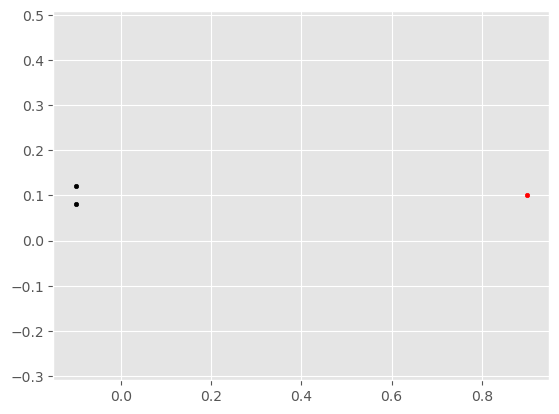

In [92]:
# let's do even simpler
epsilon = 0.02
offset = np.array([-0.1, 0.1, 0.1])

particle = np.array([1.0, 0.0, 0.0])
pole1 = np.array([0.0, epsilon, 0.0])
pole2 = np.array([0.0, -epsilon, 0.0])

particle += offset
pole1 += offset
pole2 += offset


print("Particle particle = {" + ", ".join([str(c) for c in particle]) + "};")
print("Particle pole1 = {" + ", ".join([str(c) for c in pole1]) + "};")
print("Particle pole2 = {" + ", ".join([str(c) for c in pole2]) + "};")

plt.scatter(particle[0], particle[1], color='red', s=10, label="Particle")
plt.scatter([pole1[0], pole2[0]], [pole1[1], pole2[1]], color='black', s=10, label="Poles")

plt.axis('equal')
plt.show()

Direct: -1.9988       0       0
Mono: -2  0  0
Quad: -1.9972       0       0

Prédisons ce que l'on doit obtenir.

**Force direct**:
$$
\vec{F} = -\frac{mm}{r_1^2}\hat{\vec{r}}_1 -\frac{mm}{r_2^2}\hat{\vec{r}}_1 \\
\approx \frac{(2 - \epsilon^2)  m^2}{r_0^2 + \epsilon^2}\\
= \frac{2 - 0.02^2}{1 + 0.01^2} = 1.9988
$$


We used $\cos(1-\epsilon) \approx 1 - \frac{\epsilon^2}{2}$.

**Monopole force**
$$
\vec{F} = -\frac{m \times 2m}{r_0^2} = -2
$$

As we can see, there is a small error here. Applying the quadrupole expansion should correct it partially.


**Quadrupole Force**
Let's compute Q, in only two dimensions for now:
$$
\vec{p_1} = (0, \epsilon)\\
\vec{p_2} = (0, -\epsilon)
$$

The quadrupole moment is the sum of all quadrupole moments for all particles. Let's compute only one of the two of them.
$$
Q^\epsilon_{0, 0} = 3 p^+_0 p^+_0 - 1 \times \epsilon^2 = -\epsilon^2\\
Q^\epsilon_{1, 0} = 3 p^+_1 p^+_0 - 0 = 0\\
Q^\epsilon_{0, 1} = 3 p^+_0 p^+_1 - 0 = 0\\
Q^\epsilon_{1, 1} = 3 p^+_1 p^+_1 - 1 = \epsilon^2 \times \epsilon^2\\
$$

C'est toujours du $\epsilon^2$ donc finalement les deux particules ont le même dipole. On trouve bien que le quadrupole est de trace nulle (garantie par le facteur 2 en 2d, et 3 en 3d). Ainsi:

$$
Q = \begin{pmatrix}
-2\epsilon^2 & 0 \\
0 & 2 \epsilon^2
\end{pmatrix}
$$

And 
$$
\vec{F} = \vec{F}_{mono} - \frac{m}{2} \left(
    \frac{2Q\tilde{r}}{r^5}
     + 
    \frac{5(\tilde{r}Q\tilde{r})\tilde{r}}{r^7}
\right)
$$
with $\tilde{r} = \vec{r} - \vec{r}_{COM}$. Donc, la force F, qui sera uniquement selon l'axe x par sympétries:
$$
\vec{F} = -2.00 - \frac{Q\tilde{r}}{1} - \frac{2.5(\tilde{r}Q\tilde{r}) \tilde{r}}{1}\\
= -2.00 - 2 \epsilon^2 - 5 \epsilon^2 \\
= -2.00 - 7 \epsilon^2 = 1.9972

$$

Ca correspond bien ! Mais du coup ne serait-ce pas la formule du quadrupole gravitationnel qui est en défaut ??

In [93]:
direct_force = np.array([-1.9988, 0, 0])
monopole_force = np.array([-2.0000, 0, 0])
quadrupole_force = np.array([-1.9972, 0, 0])

In [94]:
# let's do even simpler
epsilon = 0.02
offset = np.array([-0.1, 0.1, 0.1])

particle = np.array([1.0, 0.0, 0.0])
pole1 = np.array([0.0, epsilon, 0.0])
pole2 = np.array([0.0, -epsilon, 0.0])

particle += offset
pole1 += offset
pole2 += offset

df_test = pd.DataFrame({
    "m": [1, 1, 1],
    "x": [particle[0], pole1[0], pole2[0]],
    "y": [particle[1], pole1[1], pole2[1]],
    "z": [particle[2], pole1[2], pole2[2]],
}).copy(deep=True)

df_test["r"] = np.sqrt(df_test["x"]**2 + df_test["y"]**2 + df_test["z"]**2)

particle = df_test.iloc[0].copy(deep=True)
df_particles = df_test.iloc[1:].copy(deep=True)

# direct force
direct_force = np.array([.0]*3)
for i, p in df_particles.iterrows():
    r_tilde = particle[["x", "y", "z"]] - p[["x", "y", "z"]]
    r_tilde_norm = np.linalg.norm(r_tilde)
    
    direct_force += -p["m"] * particle['m'] * r_tilde / r_tilde_norm**3
direct_force_r = np.dot(direct_force, particle[["x", "y", "z"]]) / particle['r']
print("Direct force:", f'{direct_force}')


# monopole force
r_com = np.array([.0]*3)
for i, p in df_particles.iterrows():
    r_com += p["m"] * p[["x", "y", "z"]]
r_com /= df_particles["m"].sum()
m_tot = df_particles["m"].sum()


r_tilde = particle[["x", "y", "z"]] - r_com
r_tilde_norm = np.linalg.norm(r_tilde)
monopole_force = - particle['m'] * m_tot * r_tilde / r_tilde_norm**3
print("Monopole force:", monopole_force)


# quadrupole force
Q = np.zeros((3, 3))
for i, p in df_particles.iterrows():
    r_tilde = p[["x", "y", "z"]] - r_com
    print("r_tilde", r_tilde)
    Q += p["m"] * (2*np.outer(r_tilde, r_tilde) - np.eye(3)*np.linalg.norm(r_tilde)**2)
    print(Q)


r_tilde = particle[["x", "y", "z"]] - r_com
r_tilde_norm = np.linalg.norm(r_tilde)
quadrupole_force = - 0.5 * particle['m'] * (
    (
        2*Q @ r_tilde / r_tilde_norm**5 
    ) + (
        (5 * np.array(r_tilde).transpose() @ Q @ np.array(r_tilde)) * r_tilde / r_tilde_norm**7
    )
)
print("QUad",monopole_force + quadrupole_force)
print(Q)


Direct force: x   -1.998801
y    0.000000
z    0.000000
dtype: float64
Monopole force: x   -2.0
y   -0.0
z   -0.0
dtype: float64
r_tilde x    0.00
y    0.02
z    0.00
Name: 1, dtype: float64
[[-0.0004  0.      0.    ]
 [ 0.      0.0004  0.    ]
 [ 0.      0.     -0.0004]]
r_tilde x    0.00
y   -0.02
z    0.00
dtype: float64
[[-0.0008  0.      0.    ]
 [ 0.      0.0008  0.    ]
 [ 0.      0.     -0.0008]]
QUad x   -1.9972
y   -0.0000
z   -0.0000
dtype: float64
[[-0.0008  0.      0.    ]
 [ 0.      0.0008  0.    ]
 [ 0.      0.     -0.0008]]
